In [100]:
import os
os.chdir('/home/xinglong/git_local/gsoc/ssm')
from blocked_gibbs import blocked_gibbs
os.chdir('/home/xinglong/git_local/ssm-jax')
from ssm_jax.lgssm.models import LinearGaussianSSM
from ssm_jax.distributions import NormalInverseWishart as NIW, MatrixNormalInverseWishart as MNIW

from jax import random as  jr
from jax import numpy as jnp
from jax import lax, vmap

import matplotlib.pyplot as plt

In [113]:
import matplotlibo
matplotlib.rcParams['figure.figsize'] = [16, 9]

/home/xinglong/.local/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:4459: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "astype")


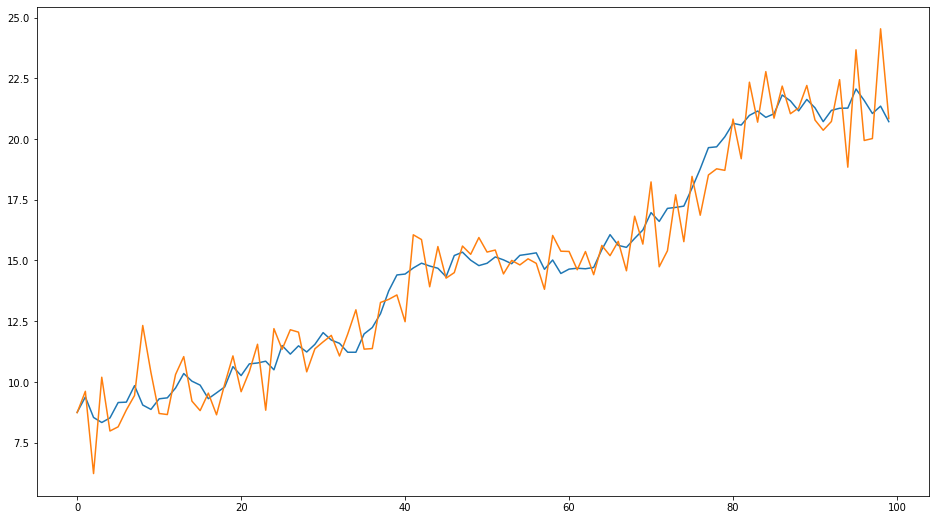

In [125]:
num_timesteps=100
key=jr.PRNGKey(0)
sample_size=3000
burn_in = 100

# Set the dimension of the system
D_obs = 1
D_hid = 1

# Set true value of the parameter
sigma_dynamics = 0.3
sigma_emission = 1

initial_mean = jnp.array([10])
initial_covariance = jnp.eye(D_hid)

Q = jnp.eye(D_hid) * sigma_dynamics
F = 1.01 * jnp.eye(D_hid) 

R = jnp.eye(D_obs) * sigma_emission
H = jnp.ones((D_obs, D_hid))

# Generate the observation
lgssm = LinearGaussianSSM(initial_mean=initial_mean,
                          initial_covariance=initial_covariance,
                          dynamics_matrix=F,
                          dynamics_covariance=Q,
                          emission_matrix=H,
                          emission_covariance=R) 

states, observations = lgssm.sample(key, num_timesteps)
plt.plot(states)
plt.plot(observations)

In [126]:
# Run the blocked gibbs sampling algorithm
log_probs, sample_params, emission_matrix_mode = blocked_gibbs(key=jr.PRNGKey(0), 
                                         sample_size=(burn_in+sample_size), 
                                         emissions=observations,
                                         D_hid=1)

In [127]:
burn_in+sample_size

3100

In [128]:
sample_params.dynamics_matrix.shape

(3100, 1, 1)

In [129]:
from ssm_jax.lgssm.inference import LGSSMParams, lgssm_posterior_sample

# sample_params = LGSSMParams(**{key: sample_params[key][burn_in:] for key in sample_params.keys()})

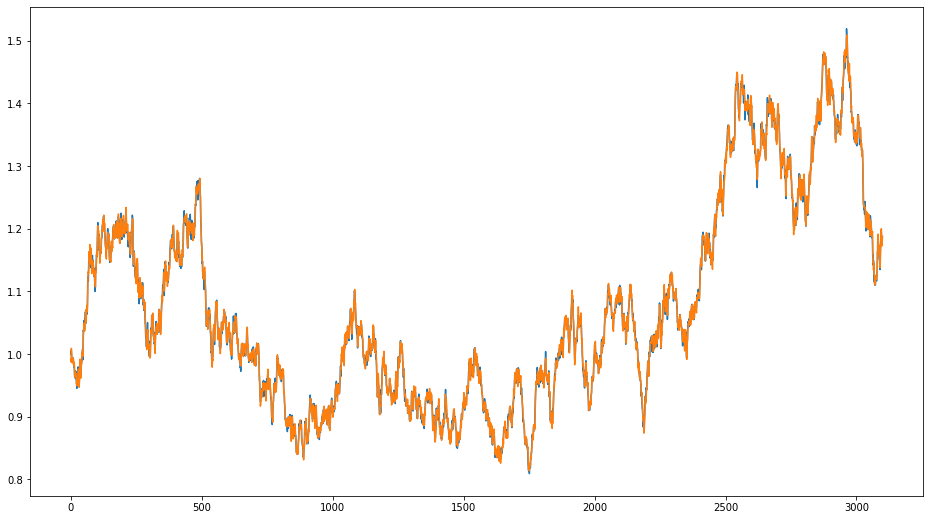

In [137]:
plt.plot(sample_params.emission_matrix.flatten())
plt.plot(emission_matrix_mode[0].flatten())

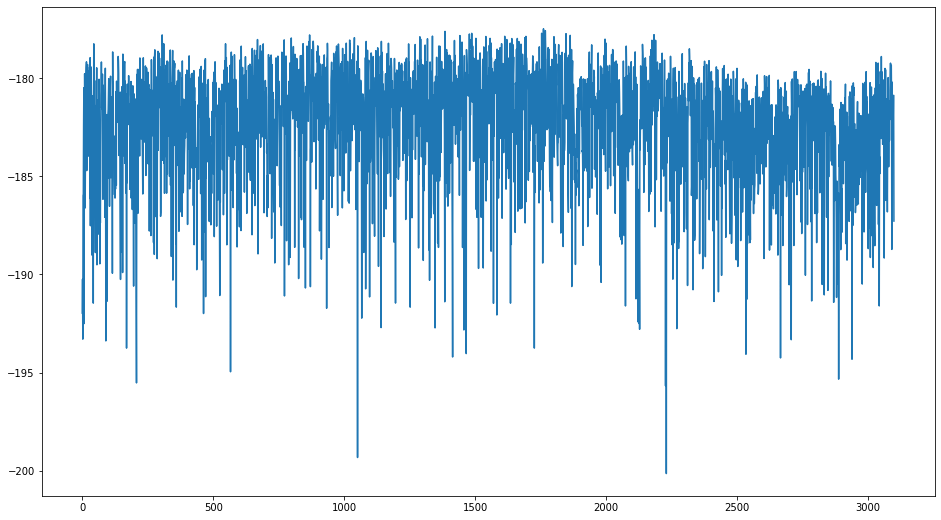

In [138]:
plt.plot(log_probs)

In [139]:
from ssm_jax.lgssm.inference import LGSSMParams, lgssm_posterior_sample
_, sample_states = vmap(lgssm_posterior_sample, in_axes=(None, 0, None))(key, sample_params, observations)

In [140]:
sample_states.shape

(3100, 100, 1)

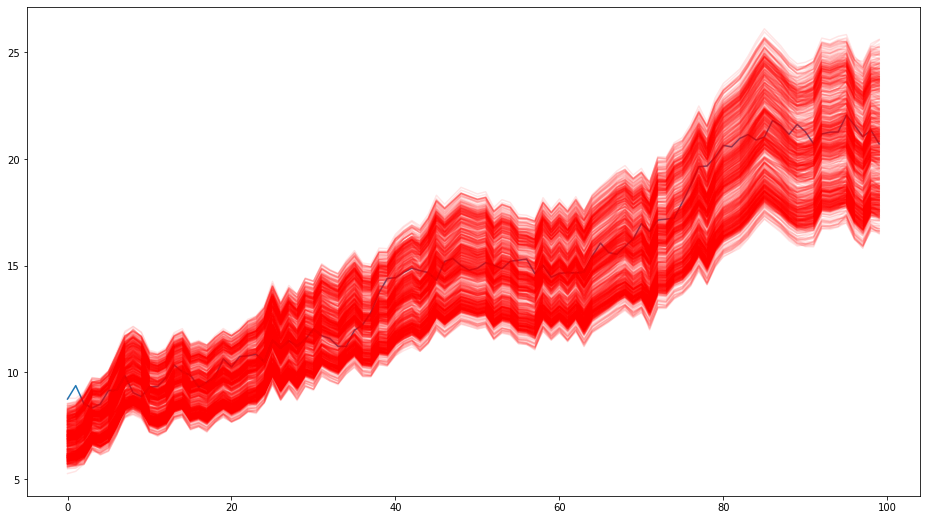

In [141]:
plt.plot(states)
t = 0
plt.plot(sample_states[t:t+1000,:,0].T, alpha=0.1, color='red')